In [ ]:
import sys
import os
import numpy as np
import random

from scipy.optimize import brentq

from qiskit import transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter, LieTrotter
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer

from gqw_ansatz import GQWAnsatz

# Go one level up to the 'main' directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add this directory to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)


In [67]:

def calc_gamma(t, T, lambda_vec: list | np.ndarray):
    l1, l2, l3, l4, l5, l6 = lambda_vec
    s = t/T

    def _x_tau_minus_s(tau):
        x_tau = 3* l1 *((1- tau)**2) * tau \
              + 3 *l3*(1- tau) * (tau**2) \
                  + tau**3 
        return (x_tau - s)
    
    if s <= 0.0:
        tau = 0.0
    elif s >= 1.0:
        tau = 1.0
    else:
        try:
            tau = brentq(_x_tau_minus_s, 0.0, 1.0)
        except ValueError:
            tau = s
    
    y_tau = ((1 - tau)**3) + \
        (3 * l2 *   ((1- tau)**2) * tau) + \
            (3 * l4 * (1 - tau) * (tau**2)) 

    start_gamma = 10 ** (2.0 * l5)
    end_gamma = 10 ** (-3.0 * l6)
    # print(start_gamma, end_gamma)
    gamma = y_tau * start_gamma + (1 - y_tau) * end_gamma

    return gamma

In [68]:
reps = 3
T = 10
delta_t = T/ reps
lambda_vec = [round(random.uniform(0, 1), 3) for i in range(4)] + [round(random.random(), 3) for _ in range(2)]

# lambda_vec = [1.76702773, 0.86898184, 1.76799968, 1.42404823, 0.84291891, 1.05100055]

hopping_rate = [calc_gamma(i*delta_t, T, lambda_vec) for i in range(reps)]
print(hopping_rate)

# cost_operator = SparsePauliOp(['IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
#               coeffs=[3.02098758+0.j, 3.07855803+0.j, 3.26645289+0.j, 2.51501527+0.j,
#  1.51608983+0.j, 1.51000473+0.j, 1.51355398+0.j, 1.51004459+0.j,
#  1.51540905+0.j, 1.51057796+0.j])

cost_operator1 = SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIIZZI', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IIZZII', 'IZIZII', 'ZIIZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[-0.00448131+0.j,  0.05142066+0.j,  0.24531016+0.j, -0.51613383+0.j,
  0.07790444+0.j,  0.05742882+0.j,  1.89872893+0.j,  1.89264375+0.j,
  1.89619306+0.j,  1.8979316 +0.j,  1.89281493+0.j,  1.89268353+0.j,
  1.89804812+0.j,  1.89925416+0.j,  1.89316156+0.j,  1.89321692+0.j,
  1.89420459+0.j,  1.89221777+0.j,  1.89941626+0.j,  1.89701067+0.j,
  1.89570455+0.j])

evolution = LieTrotter()
# evolution = None
ansatz = GQWAnsatz(cost_operator1, hopping_rate=hopping_rate, reps = reps, time = T, flatten= False, evolution= evolution)


# not clear whether to multiply with delta_t again
h_parameters = [
   delta_t * calc_gamma( i * delta_t, T, lambda_vec) for i in range (reps)
] + [delta_t for _ in range(reps)]
# h_parameters = [1, 2, 3, 4, 5, 6]

ansatz.num_parameters
ansatz.assign_parameters(h_parameters, inplace= True)


[3.6475394692560785, 2.8162000895304593, 1.590986443367707]


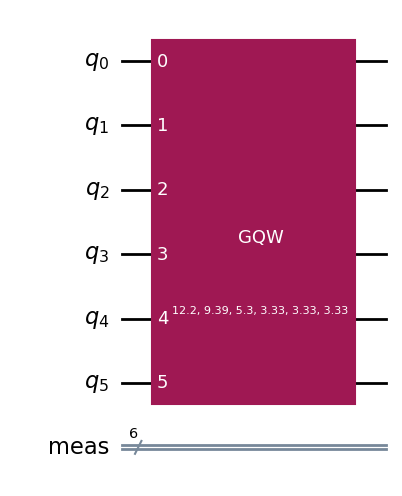

In [69]:
ansatz.draw('mpl')

In [70]:

ansatz.measure(range(4), range(4))


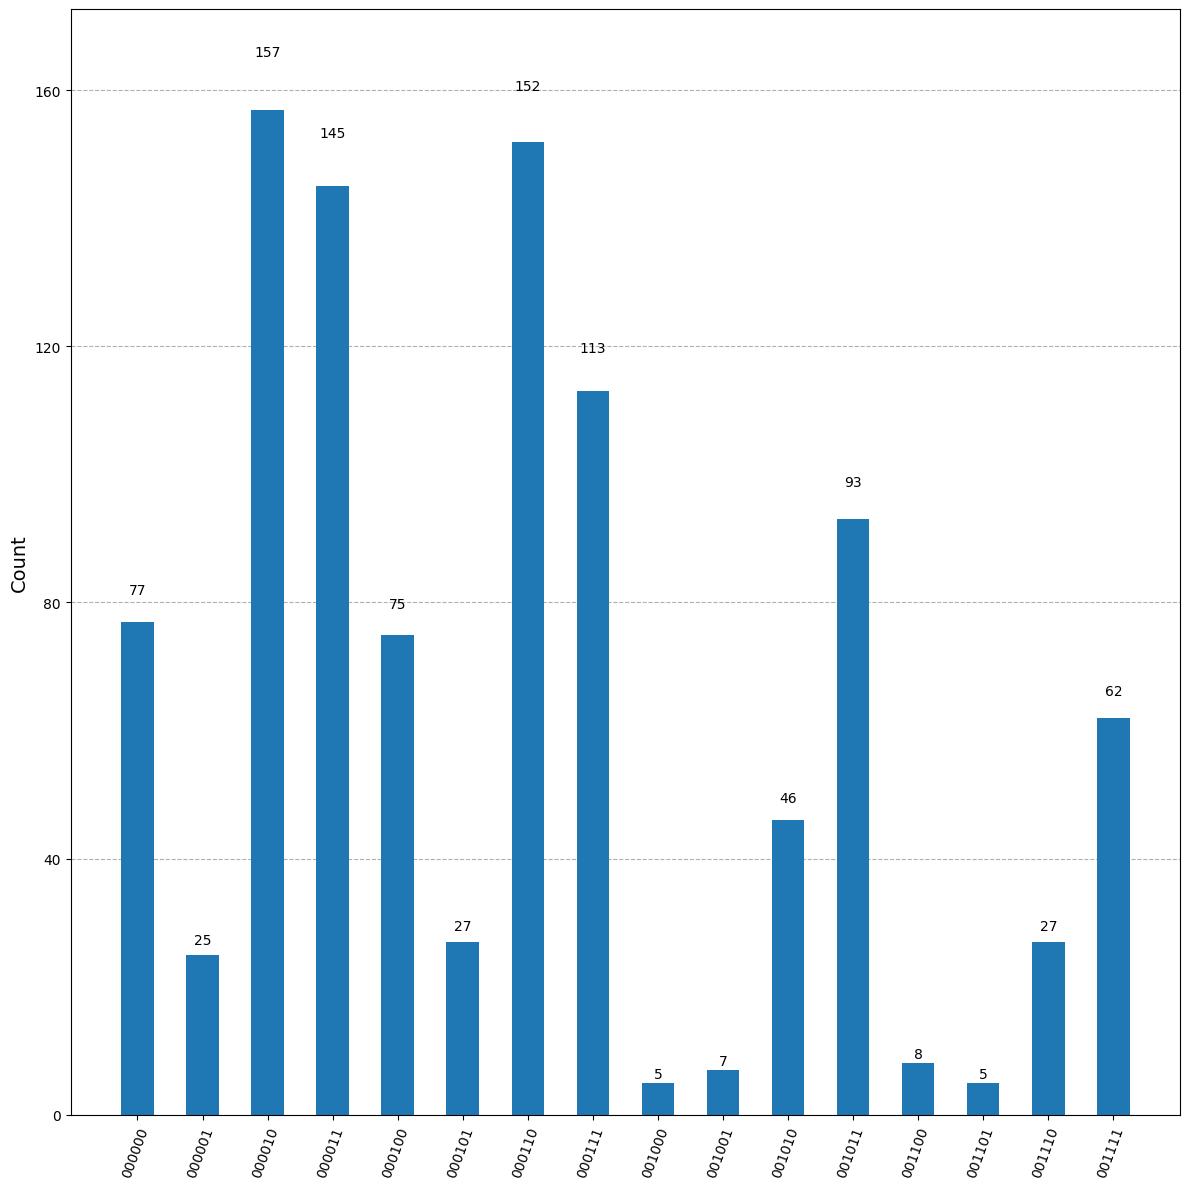

In [71]:
sim = Aer.get_backend('aer_simulator')
trasnpiled_qc = transpile(ansatz.decompose().decompose(), sim)    
result = sim.run(ansatz.decompose().decompose()).result()
counts = result.get_counts()

plot_histogram(counts, figsize= (12, 12))